# Test models performences

In [4]:
# import modules and load data
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import glob
import os

from sklearn.model_selection import train_test_split

# Load input and output data
X = np.load("../data/processed/input.npy")
Y = np.load("../data/processed/output.npy")

# TODO: Custom shuffle for RNN model
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25, shuffle=False)

# 60% train data
# 20% validation data
# 20% test data


#### Model 1

In [ ]:
# Reshape the input data (n,14) to (n,1,14)
x_train = x_train.reshape((x_train.shape[0], 1, 14))
x_test = x_test.reshape((x_test.shape[0], 1, 14))
x_val = x_val.reshape((x_val.shape[0], 1, 14))

# Adapt the normlizer layer to the feature axis in the input data
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(x_train)

# Define the model 
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(1,14)),
    normalizer,
    # layers.SimpleRNN(1024, input_shape=(1,14) ,return_sequences=False),  # or use LSTM/GRU
    layers.LSTM(1024, input_shape=(1,14), recurrent_dropout=0.2),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')  # Output a single scalar
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model (20 epochs atleast)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=32)


I0000 00:00:1748872710.895656   43788 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/ubu/.local/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/ubu/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
8012/8012 ━━━━━━━━━━━━━━━━━━━━ 136s 17ms/step - accuracy: 0.7943 - loss: 0.4430 - val_accuracy: 0.6256 - val_loss: 1.9753
Epoch 2/20
8012/8012 ━━━━━━━━━━━━━━━━━━━━ 133s 17ms/step - accuracy: 0.8337 - loss: 0.3666 - val_accuracy: 0.5801 - val_loss: 3.1754
Epoch 3/20
8012/8012 ━━━━━━━━━━━━━━━━━━━━ 132s 17ms/step - accuracy: 0.8561 - loss: 0.3251 - val_accuracy: 0.6069 - val_loss: 4.0221
Epoch 4/20
8012/8012 ━━━━━━━━━━━━━━━━━━━━ 132s 16ms/step - accuracy: 0.8694 - loss: 0.2960 - val_accuracy: 0.6096 - val_loss: 4.0540
Epoch 5/20
8012/8012 ━━━━━━━━━━━━━━━━━━━━ 133s 17ms/step - accuracy: 0.8792 - loss: 0.2754 - val_accuracy: 0.6370 - val_loss: 5.1531
Epoch 6/20
8012/8012 ━━━━━━━━━━━━━━━━━━━━ 133s 17ms/step - accuracy: 0.8847 - loss: 0.2637 - val_accuracy: 0.6441 - val_loss: 4.0735
Epoch 7/20
8012/8012 ━━━━━━━━━━━━━━━━━━━━ 133s 17ms/step - accuracy: 0.8912 - loss: 0.2492 - val_accuracy: 0.6573 - val_loss: 6.6814
Epoch 8/20
8012/8012 ━━━━━━━━━━━━━━━━━━━━ 132s 16ms/step - accuracy: 

## Test Performences

==== MODEL #1 ====
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


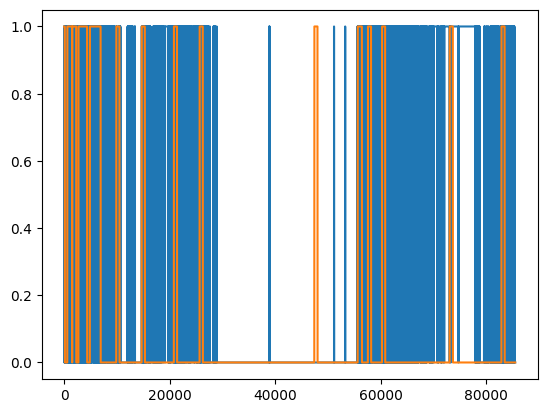

Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.59      0.72     73783
         1.0       0.20      0.67      0.31     11672

    accuracy                           0.60     85455
   macro avg       0.56      0.63      0.52     85455
weighted avg       0.82      0.60      0.66     85455



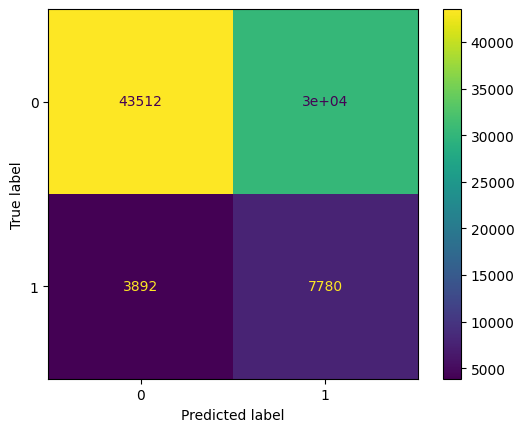

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')

# Model 1
print("==== MODEL #1 ====")

# Predict probabilities
y1_prob = model.predict(x_test)

# Convert probabilities to binary predictions (> 50% for positive prediction)
y1_pred = (y1_prob >= 0.5).astype(int).squeeze() 

# Confusion Matrix
cm1 = confusion_matrix(y_test, y1_pred)
disp1 = ConfusionMatrixDisplay(cm1)

plt.plot(range(len(y1_pred)), y1_pred, y_test)
plt.show()

# Classification Report
report1 = classification_report(y_test, y1_pred)

disp1.plot()
print("Classification Report:\n", report1)
